In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# Main Class

In [131]:
class LinearRegression:
    def __init__(self, X, y, learning_rate, epsilon, max_iteration, gd=False, sgd=False) -> None:
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iteration = max_iteration
        self.gd = gd
        self.sgd = sgd
        self.theta = None
        self.fullrank = False
        self.lowrank = False
        self.cost_history = []

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=45)
        return X_train, X_test, y_train, y_test

    def normalize_train(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_normalized = (X - mean) / std
        X_normalized = self.add_x0(X_normalized)
        return X_normalized, mean, std

    def normalize_test(self, X, mean, std):
        X_normalized = (X - mean) / std
        X_normalized = self.add_x0(X_normalized)
        return X_normalized

    def add_x0(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        return X

    def rank(self, X):
        u, s, v = np.linalg.svd(X)
        return len([x for x in s if x > 0.0005])

    def check_fullrank(self, X):
        rank = self.rank(X)
        if rank == min(X.shape):
            self.fullrank = True
            print("Full Rank")
        else:
            self.fullrank = False
            print("Not Full Rank")

    def check_lowrank(self, X):
        if X.shape[0] < X.shape[1]:
            self.lowrank = True
            print("Low Rank")
        else:
            self.lowrank = False
            print("Not Low Rank")

    def closed_form_solution(self, X, y, lambda_reg=0.0):
        if lambda_reg > 0:
            identity = np.identity(X.shape[1])
            theta = np.linalg.inv(X.T.dot(X) + lambda_reg * identity).dot(X.T).dot(y)
        else:
            theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.theta = theta
        print("Weights after Closed-form Solution:")
        print(theta)
        rmse = np.sqrt(self.cost_function(X, y, lambda_reg))
        print("RMSE:", rmse)
        print("SSE: ", self.sse(X,y))
        return theta

    def predict(self, X):
        return X.dot(self.theta)

    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y - y_hat) ** 2).sum()

    def cost_function(self, X, y, lambda_reg=0.0):
        cost = self.sse(X, y) / (2 * len(y))
        if lambda_reg > 0:
            regularization_term = (lambda_reg / (2 * len(y))) * np.sum(self.theta[1:] ** 2)
            cost += regularization_term
        return cost

    def cost_derivative(self, X, y, lambda_reg=0.0):
        y_hat = self.predict(X)
        gradient = (1 / len(y)) * X.T.dot(y_hat - y)
        if lambda_reg > 0:
            regularization_term = (lambda_reg / len(y)) * self.theta
            regularization_term[0] = 0  # No regularization for bias term
            gradient += regularization_term
        return gradient

    def gradient_descent(self, X, y, lambda_reg=0.0):
        errors = []
        prev_error = float('inf')
        self.theta = np.zeros(X.shape[1])
        for i in tqdm(range(self.max_iteration)):
            gradient = self.cost_derivative(X, y, lambda_reg)
            self.theta -= self.learning_rate * gradient
            error = self.cost_function(X, y, lambda_reg)
            errors.append(error)

            if abs(prev_error - error) < self.epsilon:
                print("Model Stopped Learning")
                break
            prev_error = error

        self.cost_history = errors
        self.plot_rmse()
        print("SSE: ", self.sse(X,y))
        print("Weights after Gradient Descent:")
        print(self.theta)
        print("Final RMSE:", np.sqrt(self.cost_history[-1]))

    def stochastic_gradient_descent(self, X, y, lambda_reg=0.0):
        errors = []
        prev_error = float('inf')
        self.theta = np.zeros(X.shape[1])
        for i in tqdm(range(self.max_iteration)):
            for j in range(X.shape[0]):
                random_idx = np.random.randint(0, X.shape[0])
                x_random = X[random_idx:random_idx + 1]
                y_random = y[random_idx:random_idx + 1]
                gradient = self.cost_derivative(x_random, y_random, lambda_reg)
                self.theta -= self.learning_rate * gradient
            error = self.cost_function(X, y, lambda_reg)
            errors.append(error)

            if abs(prev_error - error) < self.epsilon:
                print("Model Stopped Learning")
                break
            prev_error = error

        self.cost_history = errors
        self.plot_rmse()
        print("Weights after Stochastic Gradient Descent:")
        print(self.theta)
        print("SSE: ", self.sse(X,y))
        print("Final RMSE:", np.sqrt(self.cost_history[-1]))

    def fit(self, lambda_reg=0.0):
        X_train, X_test, y_train, y_test = self.split_data()
        X_train, mean, std = self.normalize_train(X_train)
        X_test = self.normalize_test(X_test, mean, std)
        self.check_fullrank(X_train)
        self.check_lowrank(X_train)

        if self.fullrank and not self.lowrank and X_train.shape[1] < 1000 and not self.gd and not self.sgd:
            self.closed_form_solution(X_train, y_train, lambda_reg)
        elif self.gd:
            self.gradient_descent(X_train, y_train, lambda_reg)
        elif self.sgd:
            self.stochastic_gradient_descent(X_train, y_train, lambda_reg)

    def plot_rmse(self):
        plt.plot(range(len(self.cost_history)), np.sqrt(self.cost_history))
        plt.xlabel("Training Steps")
        plt.ylabel("Cost (RMSE)")
        plt.title("Cost over Training Steps")
        plt.show()


# Yacth Dataset

In [132]:
yacht_df = pd.read_csv("/content/yachtData (1).csv",header=None)

In [133]:
yacht_df

,0,1,2,3,4,5,6
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
...,...,...,...,...,...,...,...
303,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
304,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
305,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
306,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


In [134]:
yacht_df.head()
X = yacht_df.drop(6,axis=1,inplace=False)
y = yacht_df[6]

In [135]:
X.shape

(308, 6)

**Closed Form**

In [136]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,False)
lr.fit()

Full Rank
Not Low Rank
Weights after Closed-form Solution:
[10.00069106 -0.01825259 -1.06685439 -0.90953693  0.97062619  1.07601739
 11.41116743]
RMSE: 6.0622515617912605
SSE:  18081.439847232763


**Gradient Descent**

Full Rank
Not Low Rank


100%|██████████| 5000/5000 [00:03<00:00, 1578.19it/s]


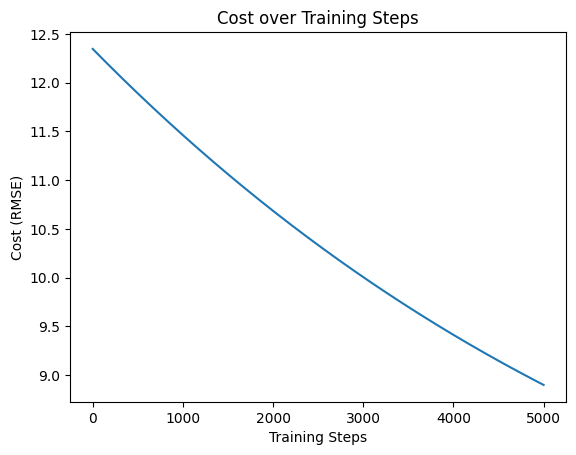

SSE:  38957.52622403679
Weights after Gradient Descent:
[ 3.93511696  0.03171472 -0.34668619  0.24959241  0.04905022  0.13251739
  4.49188424]
Final RMSE: 8.898424797119626


In [137]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,gd=True)
lr.fit()

**Stoatic Gradient Descent**

Full Rank
Not Low Rank


  4%|▎         | 176/5000 [00:12<05:51, 13.71it/s]


Model Stopped Learning


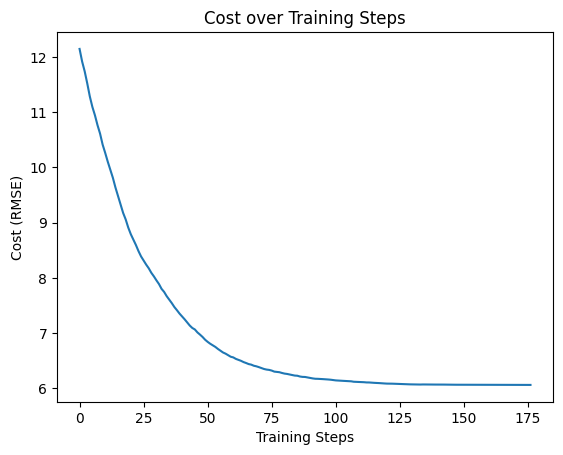

Weights after Stochastic Gradient Descent:
[ 9.93126307  0.05051969 -0.82030115  0.2383348   0.07547436  0.06581309
 11.33722059]
SSE:  18094.984770088508
Final RMSE: 6.064521772526518


In [138]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,sgd=True)
lr.fit()

# Housing Data set

In [139]:
housing_df = pd.read_csv("/content/housing (1).csv",header=None)

In [140]:
housing_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [141]:
X = housing_df.drop(13,axis=1,inplace=False)
y = housing_df[13]

In [142]:
X.shape

(506, 13)

**Closed Form**

In [143]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,False)
lr.fit()

Full Rank
Not Low Rank
Weights after Closed-form Solution:
[22.38638614 -1.03605342  1.10720075 -0.19867748  0.61130294 -2.04972393
  2.53820617  0.24101772 -3.2108561   2.59103512 -1.90790698 -1.90740413
  0.80368811 -3.7175307 ]
RMSE: 3.199216016078013
SSE:  8269.866358964298


**Gradient Descent**

Full Rank
Not Low Rank


100%|██████████| 5000/5000 [00:02<00:00, 1977.58it/s]


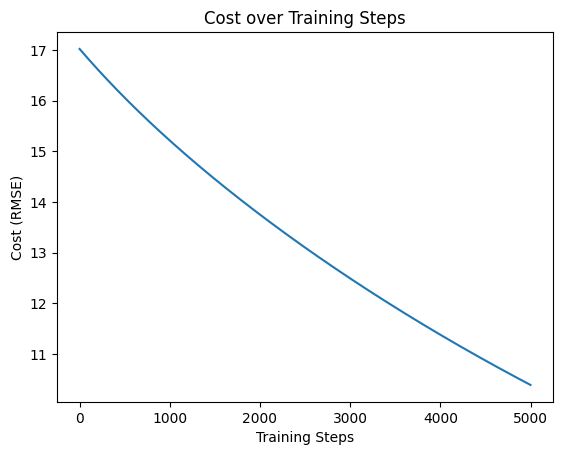

SSE:  87191.68177114357
Weights after Gradient Descent:
[ 8.80869605 -0.5495991   0.45277532 -0.6350391   0.52438635 -0.45900661
  1.73985939 -0.34920972 -0.15687491 -0.26005614 -0.53149812 -0.98189242
  0.53260293 -1.59298425]
Final RMSE: 10.38799774939879


In [144]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,gd=True)
lr.fit()

**Stoatic Gradient Descent**

Full Rank
Not Low Rank


  5%|▌         | 254/5000 [00:30<09:30,  8.33it/s]


Model Stopped Learning


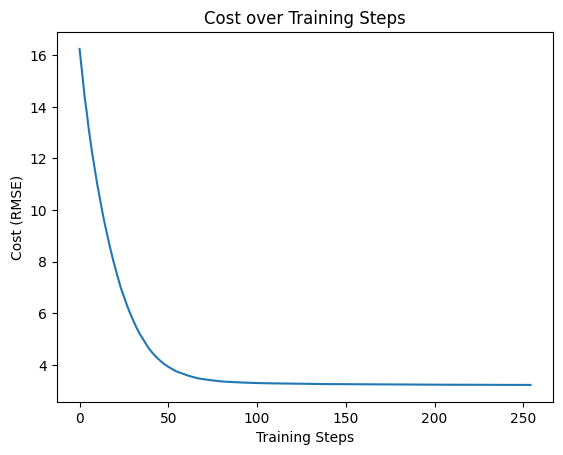

Weights after Stochastic Gradient Descent:
[22.3439144  -0.85888212  0.76476389 -0.51369326  0.67550365 -1.56967278
  2.75267859  0.12769152 -2.78998432  1.47667007 -0.84650567 -1.78110416
  0.85251769 -3.62454148]
SSE:  8375.121104443007
Final RMSE: 3.219510660277022


In [145]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,sgd=True)
lr.fit()

# Concrete Dataset

In [146]:
Concrete_df = pd.read_csv("/content/concreteData (1).csv",header=None)

In [147]:
Concrete_df

,0,1,2,3,4,5,6,7,8
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [148]:
Concrete_df.head()
X = Concrete_df.drop(8,axis=1,inplace=False)
y = Concrete_df[8]

In [149]:
X.shape

(1030, 8)

**Closed Form**

In [150]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,False)
lr.fit()

Full Rank
Not Low Rank
Weights after Closed-form Solution:
[35.9575     11.7212505   8.19227644  5.08537655 -3.56444471  1.87191317
  0.72042177  1.18931474  7.30390231]
RMSE: 7.2547633742386815
SSE:  86736.8629834894


**Gradient Descent**

Full Rank
Not Low Rank


100%|██████████| 5000/5000 [00:02<00:00, 1703.12it/s]


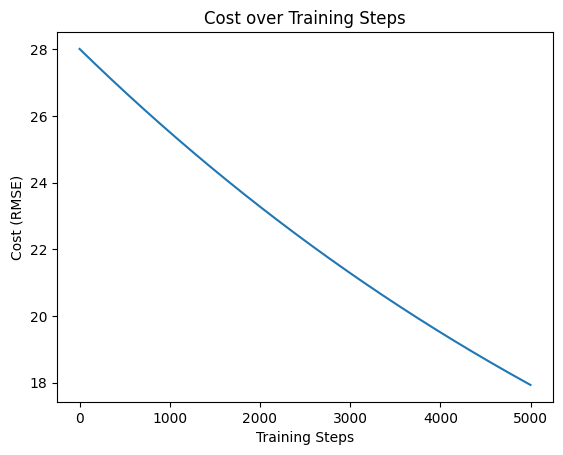

SSE:  529835.9686147219
Weights after Gradient Descent:
[14.14871907  3.05672974  0.85934454 -0.43760227 -1.82226888  2.26917716
 -1.03892778 -1.11304808  2.3619943 ]
Final RMSE: 17.93048822927031


In [151]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,gd=True)
lr.fit()

**Stoatic Gradient Descent**

Full Rank
Not Low Rank


  4%|▍         | 224/5000 [00:56<19:55,  3.99it/s]

Model Stopped Learning


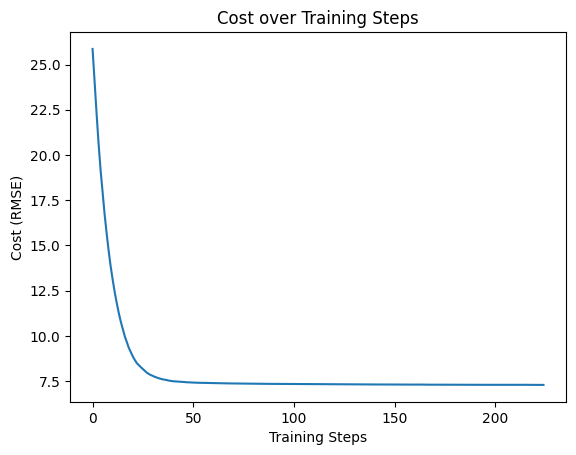

Weights after Stochastic Gradient Descent:
[35.95660563  9.06857351  5.63514008  2.82043215 -5.70517341  1.72782466
 -1.29816553 -1.37719458  7.12678911]
SSE:  87610.52872902724
Final RMSE: 7.291208994241676


In [152]:
lr = LinearRegression(X,y,0.0001,0.0001,5000,sgd=True)
lr.fit()